In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split

In [8]:
num_epochs = 20
num_classes = 4
learning_rate = 0.001
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset_path = r"C:\Users\yasse\OneDrive\Desktop\structured_data"


In [9]:
trainset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)




classes = trainset.classes

dataiter = iter(train_loader)
images, labels = next(dataiter)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


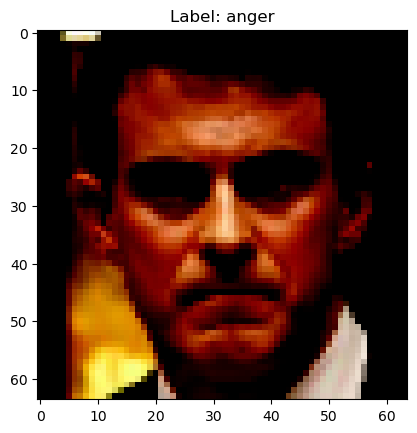

Label: anger


In [10]:
img = images[12].numpy()  # Get the 13th image in the batch (0-indexed)
label = labels[12].item()  # Get the 13th label in the batch

# Unnormalize the image for display


# Check if the image is color or grayscale
if img.shape[0] == 3:  # Color image
    img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
elif img.shape[0] == 1:  # Grayscale image
    img = np.squeeze(img)  # Remove the channel dimension

# Display the image
plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
plt.title(f'Label: {classes[label]}')
plt.show()

# Print the label
print(f'Label: {classes[label]}')

In [11]:


# Calculate the number of samples for each subset
num_train = int(0.7 * len(trainset))  # 70% for training
num_val_test = len(trainset) - num_train  # Remaining 30% for validation and testing
num_val = int(0.15 * len(trainset))  # 15% for validation
num_test = num_val_test - num_val  # 15% for testing

# Split the dataset
train_dataset, temp_dataset = random_split(trainset, [num_train, num_val_test])
val_dataset, test_dataset = random_split(temp_dataset, [num_val, num_test])

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Classes: {classes}")


Classes: ['anger', 'engaged', 'happy', 'neutral']


In [12]:
class OB_05Model(nn.Module):
    def __init__(self):
        super(OB_05Model, self).__init__()
        
        # Define the convolutional layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers with the corrected input size
        self.fc_layer = nn.Sequential(
            nn.Linear(512*4*4, 4096),  # Corrected input size
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layer(x)
        return x

In [13]:
model = OB_05Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
dummy_input = torch.randn(32, 3, 64, 64)  # Batch size of 32, 3 channels, 64x64 image
output = model(dummy_input)
print(output.shape)

torch.Size([32, 10])


Test valution with 20 epoch

In [14]:
total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    correct_epoch = 0
    total_epoch = 0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Train accuracy for the current batch
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        correct_epoch += correct
        total_epoch += total
        acc_list.append(correct / total)
        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Batch Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), 
                          (correct / total) * 100))
    
    # Epoch level accuracy
    epoch_accuracy = 100 * correct_epoch / total_epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_accuracy:.2f}%')

print('Training finished.')


Epoch [1/20], Loss: 1.3546, Accuracy: 24.52%
Epoch [2/20], Loss: 1.0678, Accuracy: 35.82%
Epoch [3/20], Loss: 0.8080, Accuracy: 53.24%
Epoch [4/20], Loss: 0.7290, Accuracy: 65.97%
Epoch [5/20], Loss: 0.4117, Accuracy: 74.06%
Epoch [6/20], Loss: 0.4318, Accuracy: 78.26%
Epoch [7/20], Loss: 0.4037, Accuracy: 80.48%
Epoch [8/20], Loss: 0.2521, Accuracy: 83.26%
Epoch [9/20], Loss: 0.6072, Accuracy: 85.67%
Epoch [10/20], Loss: 0.5908, Accuracy: 87.58%
Epoch [11/20], Loss: 0.1535, Accuracy: 89.01%
Epoch [12/20], Loss: 0.3118, Accuracy: 91.66%
Epoch [13/20], Loss: 0.1932, Accuracy: 93.27%
Epoch [14/20], Loss: 0.2981, Accuracy: 94.44%
Epoch [15/20], Loss: 0.0527, Accuracy: 95.86%
Epoch [16/20], Loss: 0.0524, Accuracy: 95.43%
Epoch [17/20], Loss: 0.0765, Accuracy: 97.04%
Epoch [18/20], Loss: 0.0199, Accuracy: 97.34%
Epoch [19/20], Loss: 0.2903, Accuracy: 97.47%
Epoch [20/20], Loss: 0.2569, Accuracy: 97.10%
Training finished.


Use the Test Data and do the evalution

In [16]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        outputs = model(images)
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of labels
        total += labels.size(0)
        # Update the number of correct predictions
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = (correct / total) * 100
print('Test Accuracy of the model on  test images: {:.2f} %'.format(accuracy))


Test Accuracy of the model on  test images: 82.47 %


this for the valution test and it evalution

In [17]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in val_loader:
        # Forward pass
        outputs = model(images)
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of labels
        total += labels.size(0)
        # Update the number of correct predictions
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = (correct / total) * 100
print('Validation Accuracy of the model: {:.2f} %'.format(accuracy))


Validation Accuracy of the model: 81.79 %


To Save A Model

In [23]:
# Define the path and file name to save the model
model_path = r"C:\Users\yasse\OneDrive\Desktop\ModelPath\model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to C:\Users\yasse\OneDrive\Desktop\ModelPath\model.pth
